# Segmenting and Clustering Neighborhoods in Toronto
## Part 1. Data wrangling

**Import all needed libraries**

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup 
import requests  

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize 
from IPython.display import Image

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



**Create url where we will scrap data**

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

**Scrapping data using BeautifulSoup**

In [3]:
data = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

**We scrap all tables from the url. There are 16 tables.**

In [4]:
tables = soup.find_all('table')
len(tables)

3

**We search our table of interest by looking for a cell value, because there is no column names.**

In [5]:
for index,table in enumerate(tables):
    if ("M3A" in str(table)):
        table_index = index
print(table_index)

0


**It is located in the position tables[0]. We look at this table**

In [6]:
print(tables[table_index].prettify())

<table cellpadding="2" cellspacing="0" rules="all" style="width:100%; border-collapse:collapse; border:1px solid #ccc;">
 <tbody>
  <tr>
   <td style="width:11%; vertical-align:top; color:#ccc;">
    <p>
     <b>
      M1A
     </b>
     <br/>
     <span style="font-size:85%;">
      <i>
       Not assigned
      </i>
     </span>
    </p>
   </td>
   <td style="width:11%; vertical-align:top; color:#ccc;">
    <p>
     <b>
      M2A
     </b>
     <br/>
     <span style="font-size:85%;">
      <i>
       Not assigned
      </i>
     </span>
    </p>
   </td>
   <td style="width:11%; vertical-align:top;">
    <p>
     <b>
      M3A
     </b>
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Parkwoods" title="Parkwoods">
       Parkwoods
      </a>
      )
     </span>
    </p>
   </td>
   <td style="width:11%; vertical-align:top;">
    <p>
     <b>
      M4A
     </b>
 

**We create the dataframe using Pandas and fill it with the data from the selected table. We don't import the last column (Map) because it is not necessary.**

In [7]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        if cell['Neighborhood'] == 'Not assigned':
            cell['Neighborhood'] = cell['Borough']
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [8]:
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [9]:
df.shape

(103, 3)

## Part 2. Setting Latitude and Longitude for each borough.

**I tried to work with Geocoder Python Package, but the package does not work well, so I downloaded the alternative csv file provided by the course.**

In [10]:
geodata = pd.read_csv('Geospatial_Coordinates.csv')
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**The csv file is pretty clean, so merging it with our data is easy:**

In [11]:
merged_df = pd.merge(df, geodata, on = "Postal Code")
merged_df.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [12]:
merged_df.shape

(103, 5)

## Part 3. Clustering the neighborhoods in Toronto
**First of all, let's see how many differents boroughs have Toronto**

In [13]:
total_boroughs = merged_df['Borough'].unique()
print("Toronto has a total of {} boroughs and {} neighborhoods.".format(len(total_boroughs), merged_df.shape[0]))

Toronto has a total of 15 boroughs and 103 neighborhoods.


**There are too many boroughs, so we reduce the analysis only to the boroughs that contain the word 'Toronto'.**

In [14]:
merged_df = merged_df[merged_df['Borough'].str.contains('Toronto')]
merged_df['Borough'].unique()

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto',
       'Downtown Toronto Stn A', 'East Toronto Business'], dtype=object)

In [15]:
total_boroughs = merged_df['Borough'].unique()
print("Toronto has a total of {} boroughs containing the word 'Toronto' and {} neighborhoods.".format(len(total_boroughs), merged_df.shape[0]))

Toronto has a total of 7 boroughs containing the word 'Toronto' and 39 neighborhoods.


**Let's obtain the mean coordinates of Toronto using geopy:**

In [16]:
address = 'Toronto City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Toronto City are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Toronto City are 43.6534817, -79.3839347.


**Let's show all the selected boroughs in a map:**

In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

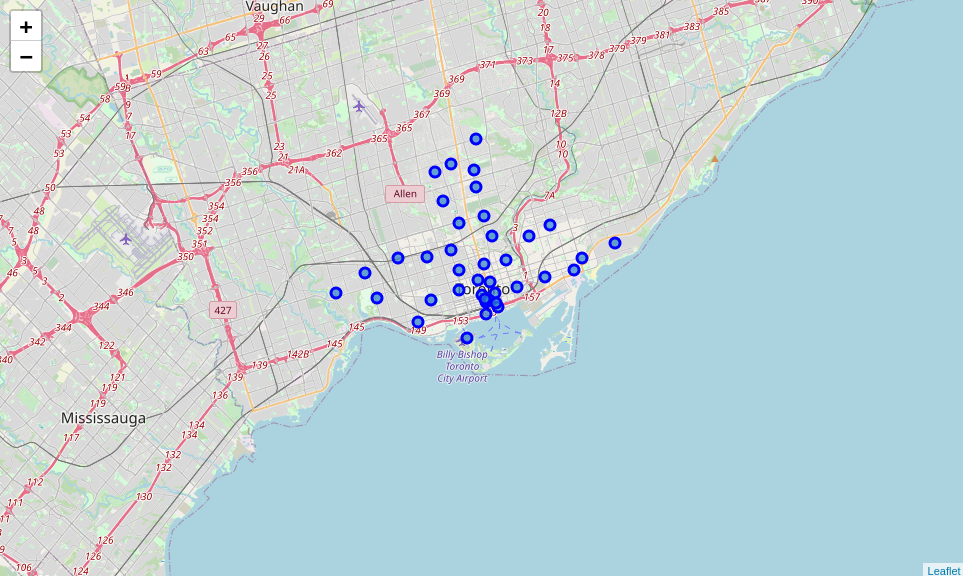

In [18]:
# Uncomment this if the map is not shown
Image('Map1.png')

**Foursquare credentials:**

In [19]:
CLIENT_ID = 'P3W22VHJK3J5DQYBFKGJHYGJJ4YBSKX4SYZXE0TSRIQ0QN2V' 
CLIENT_SECRET = 'O22ZWY20RXWJTFSKYF4AWBN1OZSD5XENSDFCP3WPXJP4ZQFN' 
VERSION = '20180605' 
LIMIT = 100 

**Creating a function able to obtain venues info**

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Now, we run the above function in order to obtain the Toronto venues information**

In [21]:
toronto_venues = getNearbyVenues(names=merged_df['Neighborhood'],
                                   latitudes=merged_df['Latitude'],
                                   longitudes=merged_df['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

**Now, we check the generated dataframe**

In [22]:
print(toronto_venues.shape)
toronto_venues.head()

(1588, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


**How many venues have we located from each borough?**

In [23]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34
Davisville North,9,9,9,9,9,9


**Checking how many unique categories we can find from all venues**

In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


### Analyzing each neighborhood

**The next step is convert all venues categories in dummy variables:**

In [25]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 


fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**We group all rows by neighborhood.**

In [26]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(5)

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0,0.066667,0.066667,0.066667,0.133333,0.2,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Central Bay Street,0.016129,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.016129
4,Christie,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


### Performing K-Means algorithm analysis

**In order to simplify, we will work with only 4 clusters. We create the object K-Means and fit the model.**

In [27]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1],
      dtype=int32)

**Now, we're going to group all the neighborhoods considering the most common venues and sorting them. To do this, we need to define a function that selects and sorts the most common venues. With these data, we create a new dataframe called 'neighborhoods_venues_sorted'.**

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Cheese Shop,Seafood Restaurant,Beer Bar,Farmers Market,Restaurant,Gourmet Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Pet Store,Bar,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Coffee Shop,Boat or Ferry,Rental Car Location,Plane,Harbor / Marina,Airport Terminal,Sculpture Garden,Airport Gate
3,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Bank,Thai Restaurant
4,Christie,Grocery Store,Café,Park,Athletics & Sports,Coffee Shop,Nightclub,Restaurant,Baby Store,Candy Store,Italian Restaurant


**We merge the neighborhoods_venues_sorted dataframe with our Toronto dataframe ('merged_df').**

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = merged_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Breakfast Spot,Pub,Café,Theater,Cosmetics Shop,Shoe Store,Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Italian Restaurant,Hotel,Bubble Tea Shop,Middle Eastern Restaurant,Café,Cosmetics Shop,Japanese Restaurant,Movie Theater
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Gastropub,Cocktail Bar,Creperie,Italian Restaurant,Department Store,Cosmetics Shop,Clothing Store,Gym
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Trail,Health Food Store,Pub,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Cheese Shop,Seafood Restaurant,Beer Bar,Farmers Market,Restaurant,Gourmet Shop


**And we show in a map the result of the K-Means clustering.**

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

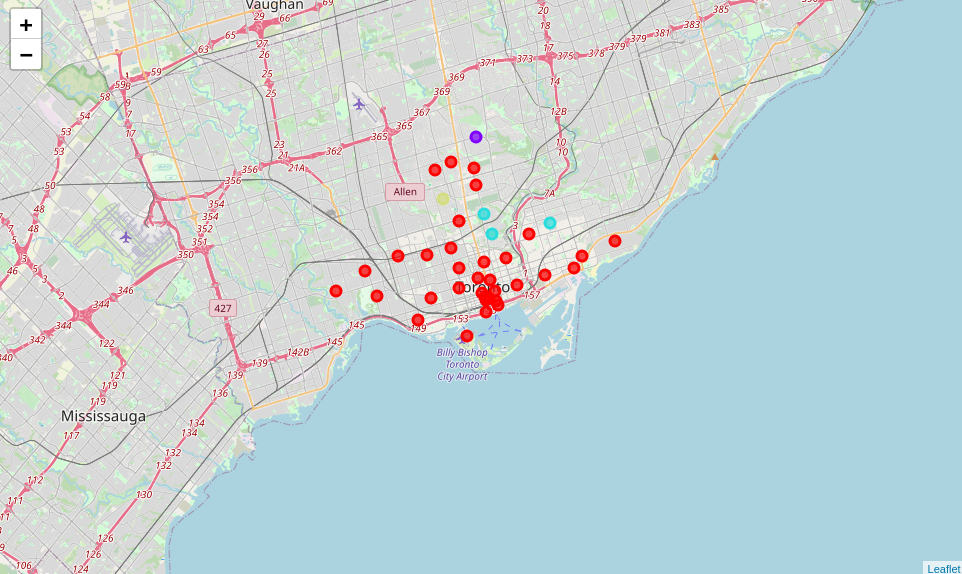

In [32]:
# Uncomment this if the map is not shown
Image('Map 2 KMeans.png')

**Finally, we will list all the clusters and the most common venues**

**Cluster 1**

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(kclusters, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,-79.360636,0,Coffee Shop,Park,Bakery,Breakfast Spot,Pub,Café,Theater,Cosmetics Shop,Shoe Store,Restaurant
9,Downtown Toronto,-79.378937,0,Coffee Shop,Clothing Store,Italian Restaurant,Hotel,Bubble Tea Shop,Middle Eastern Restaurant,Café,Cosmetics Shop,Japanese Restaurant,Movie Theater
15,Downtown Toronto,-79.375418,0,Coffee Shop,Café,Gastropub,Cocktail Bar,Creperie,Italian Restaurant,Department Store,Cosmetics Shop,Clothing Store,Gym
19,East Toronto,-79.293031,0,Coffee Shop,Trail,Health Food Store,Pub,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
20,Downtown Toronto,-79.373306,0,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Cheese Shop,Seafood Restaurant,Beer Bar,Farmers Market,Restaurant,Gourmet Shop
24,Downtown Toronto,-79.387383,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Bank,Thai Restaurant
25,Downtown Toronto,-79.422564,0,Grocery Store,Café,Park,Athletics & Sports,Coffee Shop,Nightclub,Restaurant,Baby Store,Candy Store,Italian Restaurant
30,Downtown Toronto,-79.384568,0,Coffee Shop,Café,Restaurant,Deli / Bodega,Hotel,Clothing Store,Gym,Thai Restaurant,Sushi Restaurant,Salad Place
31,West Toronto,-79.442259,0,Bakery,Pharmacy,Grocery Store,Brewery,Middle Eastern Restaurant,Bank,Bar,Café,Supermarket,Music Venue
36,Downtown Toronto,-79.381752,0,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Brewery,Italian Restaurant,Pizza Place,Scenic Lookout,Restaurant


**Cluster 2**

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(kclusters, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,-79.38879,1,Park,Swim School,Bus Line,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


**Cluster 3**

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(kclusters, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,East York/East Toronto,-79.338106,2,Park,Convenience Store,Metro Station,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
83,Central Toronto,-79.383160,2,Restaurant,Playground,Park,Colombian Restaurant,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
91,Downtown Toronto,-79.377529,2,Park,Trail,Playground,Deli / Bodega,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


**Cluster 4**

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(kclusters, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Central Toronto,-79.411307,3,Park,Trail,Jewelry Store,Sushi Restaurant,Wine Bar,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
